In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import calendar
from datetime import date

%run ../db.py
%run ../database.py
%run ../utils.py

In [ ]:
cgreen = '#27ae60'
cblue = '#2980b9'
cred = '#c0392b'
corange = '#d35400'
cgrey = '#7f8c8d'
cdark = '#2c3e50'
cwithe = '#ecf0f1'

figsize = (10, 6)

In [ ]:
spec = {
    'data_base': 'Mês',
    'meta_mensal': 'Meta Mensal',
    'liquidado_mensal': 'Liquidado Mensal',
    'dif_mensal': 'Diferença Mensal',
    'meta_acumulada': 'Meta Acumulada',
    'liquidado_acumulado': 'Liquidado Acumulado',
    'dif_acumulada': 'Diferença Acumulada'
}
fmt = {
    'data_base': date_to_month_name,
    'meta_mensal': money_formatter,
    'liquidado_mensal': money_formatter,
    'dif_mensal': money_formatter,
    'meta_acumulada': money_formatter,
    'liquidado_acumulado': money_formatter,
    'dif_acumulada': money_formatter
}

In [ ]:
def plot_acumulado(df, titulo):
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(titulo, x=0, fontsize=16)
    plt.title('valores acumulados', x=0)
    x = df['data_base'].dt.strftime('%b')
    plt.plot(x, df['meta_acumulada'], color=cblue, label='Meta', linestyle='--')
    plt.plot(x, df['liquidado_acumulado'], color=corange, label='Liquidado', marker='^')
    plt.ylim(bottom=0)
    plt.xticks(x)
    ax.yaxis.set_major_formatter(int_formatter)
    plt.legend(loc='best', ncol=4)
    plt.show()

def adiciona_data_base(df):
    last_day_of_month = []
    for month in range(df['data_base'].max().month + 1, 13):
        last_day_of_month.append(date(2023, month, calendar.monthrange(2023, month)[1]))
    for dt in last_day_of_month:
        n = pd.DataFrame([{'data_base': dt}])
        df = pd.concat([df, n])
    df = df.reset_index(drop=True)
    #df = df.drop('index', axis=1)
    return df
    
def plot_mensal(df, titulo):
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(titulo, x=0, fontsize=16)
    plt.title('valores mensais', x=0)
    x = df['data_base'].dt.strftime('%b')
    bar_width = 0.25
    x_pos = np.arange(len(x))
    plt.bar(x_pos, df['meta_mensal'], color=cgrey, label='Meta', width=bar_width, align='center')
    plt.bar(x_pos + bar_width, df['liquidado_mensal'], color=corange, label='Liquidado', width=bar_width, align='center')
    plt.ylim(bottom=0)
    ax.yaxis.set_major_formatter(int_formatter)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x)
    plt.legend(loc='best', ncol=3)
    plt.show()


# Despesas

Nesta parte são demonstradas as despesas da **Prefeitura**, excluídas, portanto, as receias do *RPPS* e da *Câmara de Vereadores*. As despesas *intra-orçamentárias* executadas são incluídas nos valores.

## Despesa Total

In [ ]:
nome_despesa = 'Despesa Total'
sql = f'''SELECT
    data_base,
    SUM(meta_mensal_atualizada) AS meta_mensal,
    SUM(valor_liquidado) AS liquidado_mensal,
    SUM(SUM(meta_mensal_atualizada)) OVER (ORDER BY data_base) AS meta_acumulada,
    SUM(SUM(valor_liquidado)) OVER (ORDER BY data_base) AS liquidado_acumulado
FROM pad."DESPESA"
WHERE
    entidade = 'pm' AND exercicio = {controle_ano}
    AND controle BETWEEN {controle_ano}01 AND {controle_ano}12
GROUP BY data_base
ORDER BY data_base ASC;
'''
#print(sql)
despesa = sqldf(sql)
despesa = adiciona_data_base(despesa)
despesa['dif_mensal'] = round(despesa['liquidado_mensal'] - despesa['meta_mensal'])
despesa['dif_acumulada'] = round(despesa['liquidado_acumulado'] - despesa['meta_acumulada'])
despesa['data_base'] = pd.to_datetime(despesa['data_base'], format='%Y-%m-%d')
#despesa


In [ ]:
acumulado = despesa.copy()
plot_acumulado(acumulado, nome_despesa)

In [ ]:
mensal = despesa.copy()
plot_mensal(mensal, nome_despesa)

In [ ]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_despesa} - {dt.year}').hide(axis='index')
#df

## Despesa Corrente

In [ ]:
nome_despesa = 'Despesa Corrente'
sql = f'''SELECT
    data_base,
    SUM(meta_mensal_atualizada) AS meta_mensal,
    SUM(valor_liquidado) AS liquidado_mensal,
    SUM(SUM(meta_mensal_atualizada)) OVER (ORDER BY data_base) AS meta_acumulada,
    SUM(SUM(valor_liquidado)) OVER (ORDER BY data_base) AS liquidado_acumulado
FROM pad."DESPESA"
WHERE
    entidade = 'pm' AND exercicio = {controle_ano}
    AND controle BETWEEN {controle_ano}01 AND {controle_ano}12
    AND elemento LIKE '3%%'
GROUP BY data_base
ORDER BY data_base ASC;
'''
#print(sql)
despesa = sqldf(sql)
despesa = adiciona_data_base(despesa)
despesa['dif_mensal'] = round(despesa['liquidado_mensal'] - despesa['meta_mensal'])
despesa['dif_acumulada'] = round(despesa['liquidado_acumulado'] - despesa['meta_acumulada'])
despesa['data_base'] = pd.to_datetime(despesa['data_base'], format='%Y-%m-%d')
#despesa


In [ ]:
acumulado = despesa.copy()
plot_acumulado(acumulado, nome_despesa)

In [ ]:
mensal = despesa.copy()
plot_mensal(mensal, nome_despesa)

In [ ]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_despesa} - {dt.year}').hide(axis='index')
#df

## Despesa com Pessoal e Encargos Sociais

In [ ]:
nome_despesa = 'Despesa com Pessoal e Encargos Sociais'
sql = f'''SELECT
    data_base,
    SUM(meta_mensal_atualizada) AS meta_mensal,
    SUM(valor_liquidado) AS liquidado_mensal,
    SUM(SUM(meta_mensal_atualizada)) OVER (ORDER BY data_base) AS meta_acumulada,
    SUM(SUM(valor_liquidado)) OVER (ORDER BY data_base) AS liquidado_acumulado
FROM pad."DESPESA"
WHERE
    entidade = 'pm' AND exercicio = {controle_ano}
    AND controle BETWEEN {controle_ano}01 AND {controle_ano}12
    AND elemento LIKE '31%%'
GROUP BY data_base
ORDER BY data_base ASC;
'''
#print(sql)
despesa = sqldf(sql)
despesa = adiciona_data_base(despesa)
despesa['dif_mensal'] = round(despesa['liquidado_mensal'] - despesa['meta_mensal'])
despesa['dif_acumulada'] = round(despesa['liquidado_acumulado'] - despesa['meta_acumulada'])
despesa['data_base'] = pd.to_datetime(despesa['data_base'], format='%Y-%m-%d')
#despesa


In [ ]:
acumulado = despesa.copy()
plot_acumulado(acumulado, nome_despesa)

In [ ]:
mensal = despesa.copy()
plot_mensal(mensal, nome_despesa)

In [ ]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_despesa} - {dt.year}').hide(axis='index')
#df

## Despesa de Custeio

Outras despesas correntes, exceto pessoal, encargos sociais e juros da dívida.

In [ ]:
nome_despesa = 'Despesa de Custeio - exceto pessoal'
sql = f'''SELECT
    data_base,
    SUM(meta_mensal_atualizada) AS meta_mensal,
    SUM(valor_liquidado) AS liquidado_mensal,
    SUM(SUM(meta_mensal_atualizada)) OVER (ORDER BY data_base) AS meta_acumulada,
    SUM(SUM(valor_liquidado)) OVER (ORDER BY data_base) AS liquidado_acumulado
FROM pad."DESPESA"
WHERE
    entidade = 'pm' AND exercicio = {controle_ano}
    AND controle BETWEEN {controle_ano}01 AND {controle_ano}12
    AND elemento LIKE '33%%'
GROUP BY data_base
ORDER BY data_base ASC;
'''
#print(sql)
despesa = sqldf(sql)
despesa = adiciona_data_base(despesa)
despesa['dif_mensal'] = round(despesa['liquidado_mensal'] - despesa['meta_mensal'])
despesa['dif_acumulada'] = round(despesa['liquidado_acumulado'] - despesa['meta_acumulada'])
despesa['data_base'] = pd.to_datetime(despesa['data_base'], format='%Y-%m-%d')
#despesa


In [ ]:
acumulado = despesa.copy()
plot_acumulado(acumulado, nome_despesa)

In [ ]:
mensal = despesa.copy()
plot_mensal(mensal, nome_despesa)

In [ ]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_despesa} - {dt.year}').hide(axis='index')
#df

## Despesa por Órgãos

In [74]:
nome_despesa = 'Despesa por Órgãos'
sql = f'''
SELECT
    nome_orgao,
    SUM(valor_liquidado) AS liquidado
FROM pad."BAL_DESP"
WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
GROUP BY
    nome_orgao
ORDER BY
    liquidado DESC
'''
#print(sql)
despesa_atual = sqldf(sql)

despesa = despesa_atual


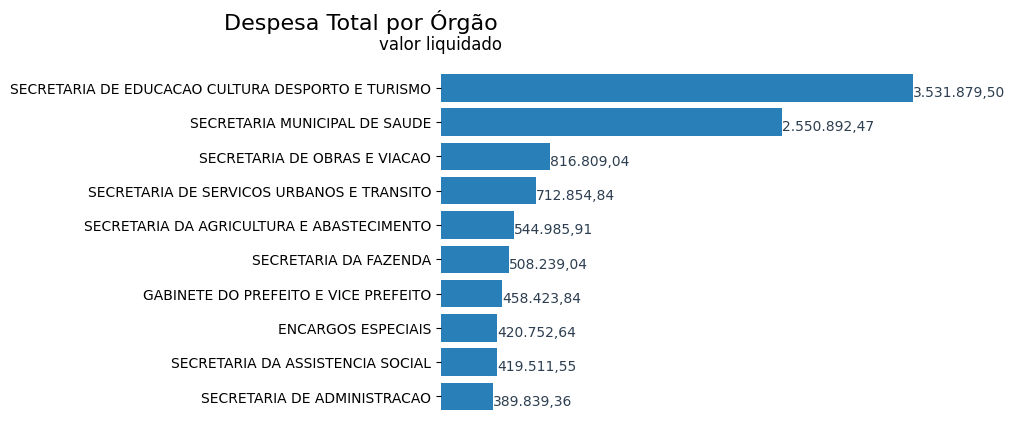

In [75]:
fig, ax = plt.subplots()
fig.suptitle('Despesa Total por Órgão', x=0, fontsize=16)
plt.title('valor liquidado', x=0)
orgaos = despesa['nome_orgao']
ax.barh(orgaos, despesa['liquidado'], color=cblue)
ax.invert_yaxis()
for i, v in enumerate(despesa['liquidado']):
    ax.text(v + 3, i + 0.25, money_formatter(v), color=cdark)
ax.set_xticks([])
ax.set_frame_on(False)
plt.show()

In [76]:
df = df_table(despesa.copy(), spec={
    'nome_orgao': 'Órgão',
    'liquidado': 'Liquidado'
}, fmt={
    'liquidado': money_formatter
})
df.style.set_caption(f'{nome_despesa} - valores acumulados - {dt.year}').hide(axis='index')
#df

Órgão,Liquidado
SECRETARIA DE EDUCACAO CULTURA DESPORTO E TURISMO,"3.531.879,50"
SECRETARIA MUNICIPAL DE SAUDE,"2.550.892,47"
SECRETARIA DE OBRAS E VIACAO,"816.809,04"
SECRETARIA DE SERVICOS URBANOS E TRANSITO,"712.854,84"
SECRETARIA DA AGRICULTURA E ABASTECIMENTO,"544.985,91"
SECRETARIA DA FAZENDA,"508.239,04"
GABINETE DO PREFEITO E VICE PREFEITO,"458.423,84"
ENCARGOS ESPECIAIS,"420.752,64"
SECRETARIA DA ASSISTENCIA SOCIAL,"419.511,55"
SECRETARIA DE ADMINISTRACAO,"389.839,36"
